In [1]:
import cv2
import google.colab.patches as colab
import matplotlib.pyplot as plt
import numpy

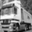

In [2]:
in_mat = cv2.imread("/content/drive/MyDrive/Colab Notebooks/LBP_local binary pattern/cifar10.bmp", 0)
colab.cv2_imshow(in_mat)

In [3]:
map = numpy.array([0, 1,  2,  3,  4, 58,  5,  6,  7, 58, 58, 58,
           8, 58,  9, 10, 11, 58, 58, 58, 58, 58, 58, 58,
          12, 58, 58, 58, 13, 58, 14, 15, 16, 58, 58, 58, 58, 58, 58, 58,
          58, 58, 58, 58, 58, 58, 58, 58, 17, 58, 58, 58, 58, 58, 58, 58,
          18, 58, 58, 58, 19, 58, 20, 21, 22, 58, 58, 58, 58, 58, 58, 58,
          58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58,
          58, 58, 58, 58, 58, 58, 58, 58, 23, 58, 58, 58, 58, 58, 58, 58,
          58, 58, 58, 58, 58, 58, 58, 58, 24, 58, 58, 58, 58, 58, 58, 58,
          25, 58, 58, 58, 26, 58, 27, 28, 29, 30, 58, 31, 58, 58, 58, 32,
          58, 58, 58, 58, 58, 58, 58, 33, 58, 58, 58, 58, 58, 58, 58, 58,
          58, 58, 58, 58, 58, 58, 58, 34, 58, 58, 58, 58, 58, 58, 58, 58,
          58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58,
          58, 58, 58, 58, 58, 58, 58, 35, 36, 37, 58, 38, 58, 58, 58, 39,
          58, 58, 58, 58, 58, 58, 58, 40, 58, 58, 58, 58, 58, 58, 58, 58,
          58, 58, 58, 58, 58, 58, 58, 41, 42, 43, 58, 44, 58, 58, 58, 45,
          58, 58, 58, 58, 58, 58, 58, 46, 47, 48, 58, 49, 58, 58, 58, 50,
          51, 52, 58, 53, 54, 55, 56, 57])

In [4]:
LBP_hist = numpy.zeros(59, dtype=numpy.float32)

In [5]:
# define the offsets of 8 neighbor points
neighbor_offset = numpy.array([[0, 1], [-1, 1], [-1, 0], [-1, -1],
                [0, -1], [1, -1], [1, 0], [1, 1]])


get the rows and cols of the input image

In [6]:
rows = in_mat.shape[0]
cols = in_mat.shape[1]

In [7]:
for row in range(1,rows-1):
  for col in range(1, cols-1):
  
    # get the center intensity
    g = in_mat[row, col]

    # threshold neighbor intensity by g
    code_256L = 0
    mask = 0x01

    for i in range(len(neighbor_offset)):
      neighbor_pos = [row, col] + neighbor_offset[i]

      # get the intensity of ith neighbor point
      g_i = in_mat[neighbor_pos[0], neighbor_pos[1]]

      # binarization
      if g_i >= g:
        code_256L = code_256L | mask
      
      # shift one-bit left
      mask = mask << 1

    # voting
    code_59L = map[code_256L]
    LBP_hist[code_59L] = LBP_hist[code_59L] + 1
    

perform the normalization and polt the LBP histogram

<BarContainer object of 59 artists>

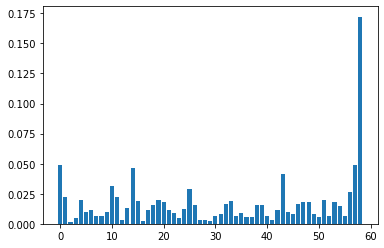

In [8]:
LBP_hist = LBP_hist / ((rows-2) * (cols-2))
plt.bar(range(LBP_hist.shape[0]), LBP_hist)